In [68]:
Base.:(==)(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] == s2[1]) && (s1[2] == s2[2])
Base.:+(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] + s2[1], s1[2] + s2[2])
Base.:-(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] - s2[1], s1[2] - s2[2])
Base.:(==)(s1::Tuple{Tuple{Int,Int},Tuple{Int,Int}}, s2::Tuple{Tuple{Int,Int},Tuple{Int,Int}}) = (s1[1] == s2[1]) && (s1[2] == s2[2])
Base.:(==)(s1::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}, s2::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}) = (s1[1] == s2[1]) && (s1[2] == s2[2]) && (s1[3] == s2[3])
state =  [(0,0),(1,0),(2,0),(3,0),(0,1),(1,1),(2,1),(-1,2),
(0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),
(8,2),(4,1),(5,0),(6,0),(7,0),(7,1),(8,1),(9,0),(-100,-100)]
action =[(1,0),(0,1),(-1,1),(-1,0),(0,-1),(1,-1)]
nS = length(state) + 1
nA = 6
s_absorbing = nS
dict_T = zeros(Float64,nS,nA,nS)
dict_R = zeros(Float64,nS,nA)
r_bump_border = -1
discountFactor = 1
p_intended = 0.8
special_hex_rewards = Dict{Tuple{Int,Int}, Float64}(
    (0,1)=>  5.0, # left side reward
    (2,0)=>-10.0, # left side hazard
    (9,0)=> 10.0, # right side reward
)
p_veer = 0.05
function hex_neighbors(hex::Tuple{Int,Int})
    i,j = hex
    [(i+1,j),(i,j+1),(i-1,j+1),(i-1,j),(i,j-1),(i+1,j-1)]
end
function T(s,a,s′)
    indexS = findfirst(k -> k == s,state)
    indexA = findfirst(k -> k == a,action)
    indexSp = findfirst(k -> k == s′,state)
    return dict_T[indexS,indexA,indexSp]
end
function R(s,a)
    indexS = findfirst(k -> k == s,state)
    indexA = findfirst(k -> k == a,action)
    return dict_R[indexS,indexA]
end


function calcTransitionAndReward(hexes::Vector{Tuple{Int,Int}},dict_T,dict_R)
    for s in 1 : length(hexes)
        hex = hexes[s]
        if !haskey(special_hex_rewards, hex)
            # Action taken from a normal tile
            neighbors = hex_neighbors(hex)
            for (a,neigh) in enumerate(neighbors)
                # Indended transition.
                s′ = findfirst(h -> h == neigh, hexes)
                if s′ == nothing
                    # Off the map!
                    s′ = s
                    dict_R[s,a] += r_bump_border*p_intended
                end
                dict_T[s,a,s′] += p_intended

                # Unintended veer left.
                a_left = mod1(a+1, nA)
                neigh_left = neighbors[a_left]
                s′ = findfirst(h -> h == neigh_left, hexes)
                if s′ == nothing
                    # Off the map!
                    s′ = s
                    dict_R[s,a] += r_bump_border*p_veer
                end
                dict_T[s,a,s′] += p_veer

                # Unintended veer right.
                a_right = mod1(a-1, nA)
                neigh_right = neighbors[a_right]
                s′ = findfirst(h -> h == neigh_right, hexes)
                if s′ == nothing
                    # Off the map!
                    s′ = s
                    dict_R[s,a] += r_bump_border*p_veer
                end
                dict_T[s,a,s′] += p_veer
            end
        else
            # Action taken from an absorbing hex
            # In absorbing hex, your action automatically takes you to the absorbing state and you get the reward.
            for a in 1 : nA
                dict_T[s,a,s_absorbing] = 1.0
                dict_R[s,a] += special_hex_rewards[hex]
            end
        end
    end

    # Absorbing state stays where it is and gets no reward.
    for a in 1 : nA
        dict_T[s_absorbing,a,s_absorbing] = 1.0
    end
end
struct MDP
    γ # discount factor
    𝒮 # state space
    𝒜 # action space
    T # transition function
    R # reward function
    TR # sample transition and reward
end
MDP(γ, 𝒮, 𝒜, T, R) = MDP(γ, 𝒮, 𝒜, T, R, nothing)

function lookahead(𝒫::MDP, U, s, a)
    𝒮, T, R, γ = 𝒫.𝒮, 𝒫.T, 𝒫.R, 𝒫.γ
    return R(s,a) + γ*sum(T(s,a,s′)*U(s′) for s′ in 𝒮)
end

function lookahead(𝒫::MDP, U::Vector, s, a)
    𝒮, T, R, γ = 𝒫.𝒮, 𝒫.T, 𝒫.R, 𝒫.γ
    return R(s,a) + γ*sum(T(s,a,s′)*U[i] for (i,s′) in enumerate(𝒮))
end

struct ValueFunctionPolicy
    𝒫 # problem
    U # utility function
end

function greedy(𝒫::MDP, U, s)
    u, a = _findmax(a->lookahead(𝒫, U, s, a), 𝒫.𝒜)
    return (a=a, u=u)
end

function (π::ValueFunctionPolicy)(s)
    return greedy(π.𝒫, π.U, s).a
end

function backup(𝒫::MDP, U, s)
    return maximum(lookahead(𝒫, U, s, a) for a in 𝒫.𝒜)
end
struct ValueIteration
    k_max # maximum number of iterations
end


function solve(M::ValueIteration, 𝒫::MDP)
    U = [0.0 for s in 𝒫.𝒮]
    for k = 1:M.k_max
        U = [backup(𝒫, U, s) for s in 𝒫.𝒮]
    end
    return ValueFunctionPolicy(𝒫, U)
end


calcTransitionAndReward(state,dict_T,dict_R)
M = ValueIteration(10)
MD = MDP(discountFactor,state,action,T,R)
value = solve(M,MD).U

25-element Vector{Float64}:
   4.391673291765723
   4.441792623507813
 -10.0
   2.418489196040919
   5.0
   4.44417925835293
   3.559757355192774
   4.3916732917657235
   4.441792623507813
   3.9554090050618163
   ⋮
   7.74955844326797
   4.588343400975003
   5.140223912900002
   5.912836438400003
   6.777365075050003
   7.749558443269923
   8.777777769
  10.0
  -5.8618940391000045

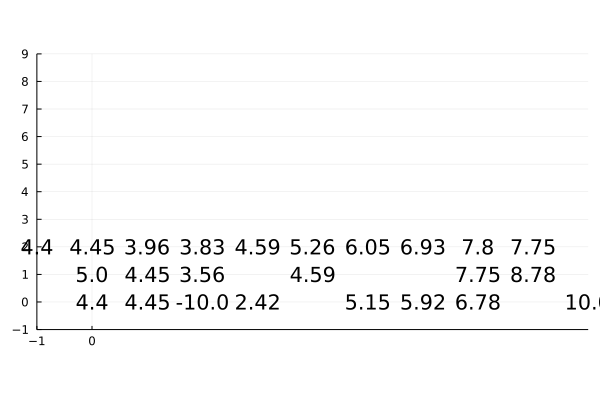

In [72]:
using Plots
gr()
plot(xticks = -1:0, yticks = -1:9, xlim = (-1, 9), ylim = (-1,9), aspect_ratio = 0.5)
annotate!(map(x -> x[1],state),map(x -> x[2],state),map(x -> ceil(x,digits=2),value))
